In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext

from pyspark.mllib.clustering import KMeans, KMeansModel

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '2')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]
sc = pyspark.SparkContext(appName="Clustering", master='spark://polyp1:7077',conf = config )

4115 srs418


In [3]:
data = sc.textFile("/scratch/ISE495/lab_05_Clustering/nutrient.dat")


In [8]:
data.take(5)

[u'BEEF BRAISED,340,20,28,9,2.6',
 u'HAMBURGER,245,21,17,9,2.7',
 u'BEEF ROAST,420,15,39,7,2.0',
 u'BEEF STEAK,375,19,32,9,2.6',
 u'BEEF CANNED,180,22,10,17,3.7']

In [9]:
type(data)

pyspark.rdd.RDD

In [4]:
import numpy as np

In [10]:
parsedData = data.map(lambda s: s.split(",")).map(lambda a: [a[0], [ float(i) for i  in a[1:]  ]    ])
parsedData = parsedData.cache()

In [7]:
type(parsedData)

pyspark.rdd.PipelinedRDD

In [31]:
parsedData.take(100)

[[u'BEEF BRAISED', [340.0, 20.0, 28.0, 9.0, 2.6]],
 [u'HAMBURGER', [245.0, 21.0, 17.0, 9.0, 2.7]],
 [u'BEEF ROAST', [420.0, 15.0, 39.0, 7.0, 2.0]],
 [u'BEEF STEAK', [375.0, 19.0, 32.0, 9.0, 2.6]],
 [u'BEEF CANNED', [180.0, 22.0, 10.0, 17.0, 3.7]],
 [u'CHICKEN BROILED', [115.0, 20.0, 3.0, 8.0, 1.4]],
 [u'CHICKEN CANNED', [170.0, 25.0, 7.0, 12.0, 1.5]],
 [u'BEEF HEART', [160.0, 26.0, 5.0, 14.0, 5.9]],
 [u'LAMB LEG ROAST', [265.0, 20.0, 20.0, 9.0, 2.6]],
 [u'LAMB SHOULDER ROAST', [300.0, 18.0, 25.0, 9.0, 2.3]],
 [u'SMOKED HAM', [340.0, 20.0, 28.0, 9.0, 2.5]],
 [u'PORK ROAST', [340.0, 19.0, 29.0, 9.0, 2.5]],
 [u'PORK SIMMERED', [355.0, 19.0, 30.0, 9.0, 2.4]],
 [u'BEEF TONGUE', [205.0, 18.0, 14.0, 7.0, 2.5]],
 [u'VEAL CUTLET', [185.0, 23.0, 9.0, 9.0, 2.7]],
 [u'BLUEFISH BAKED', [135.0, 22.0, 4.0, 25.0, 0.6]],
 [u'CLAMS RAW', [70.0, 11.0, 1.0, 82.0, 6.0]],
 [u'CLAMS CANNED', [45.0, 7.0, 1.0, 74.0, 5.4]],
 [u'CRABMEAT CANNED', [90.0, 14.0, 2.0, 38.0, 0.8]],
 [u'HADDOCK FRIED', [135.0, 16.0, 5

In [15]:
parsedData.values()

PythonRDD[6] at RDD at PythonRDD.scala:48

In [57]:
k = 4
clusters = KMeans.train(parsedData.values(), k, maxIterations=10, initializationMode="random")


In [58]:
clusters.centers

[array([ 361.66666667,   18.66666667,   31.        ,    8.66666667,
           2.43333333]),
 array([ 270.        ,   19.66666667,   20.66666667,    9.        ,
           2.53333333]),
 array([ 113.33333333,   16.        ,    4.33333333,  156.16666667,
           3.16666667]),
 array([ 161.66666667,   20.5       ,    7.5       ,   14.25      ,    1.925     ])]

In [22]:
print  clusters.predict([ 148.55555556,   19.        ,    6.44444444,   61.55555556,
           2.33888889] )
print  clusters.predict( [ 331.11111111,   19.        ,   27.55555556,    8.77777778,
           2.46666667] )


0
1


In [59]:
parsedData.map(lambda s: [s[0],clusters.predict(s[1])]).take(100)

[[u'BEEF BRAISED', 0],
 [u'HAMBURGER', 1],
 [u'BEEF ROAST', 0],
 [u'BEEF STEAK', 0],
 [u'BEEF CANNED', 3],
 [u'CHICKEN BROILED', 3],
 [u'CHICKEN CANNED', 3],
 [u'BEEF HEART', 3],
 [u'LAMB LEG ROAST', 1],
 [u'LAMB SHOULDER ROAST', 1],
 [u'SMOKED HAM', 0],
 [u'PORK ROAST', 0],
 [u'PORK SIMMERED', 0],
 [u'BEEF TONGUE', 3],
 [u'VEAL CUTLET', 3],
 [u'BLUEFISH BAKED', 3],
 [u'CLAMS RAW', 2],
 [u'CLAMS CANNED', 2],
 [u'CRABMEAT CANNED', 3],
 [u'HADDOCK FRIED', 3],
 [u'MACKEREL BROILED', 3],
 [u'MACKEREL CANNED', 2],
 [u'PERCH FRIED', 3],
 [u'SALMON CANNED', 2],
 [u'SARDINES CANNED', 2],
 [u'TUNA CANNED', 3],
 [u'SHRIMP CANNED', 2]]

In [60]:
for kv in parsedData.map(lambda s: [clusters.predict(s[1]),  [s[0],s[1][0] ]   ]).groupByKey().collect():
    print "-------\n Cluster",kv[0]
    for v in kv[1]:
        print v

-------
 Cluster 0
[u'BEEF BRAISED', 340.0]
[u'BEEF ROAST', 420.0]
[u'BEEF STEAK', 375.0]
[u'SMOKED HAM', 340.0]
[u'PORK ROAST', 340.0]
[u'PORK SIMMERED', 355.0]
-------
 Cluster 2
[u'CLAMS RAW', 70.0]
[u'CLAMS CANNED', 45.0]
[u'MACKEREL CANNED', 155.0]
[u'SALMON CANNED', 120.0]
[u'SARDINES CANNED', 180.0]
[u'SHRIMP CANNED', 110.0]
-------
 Cluster 1
[u'HAMBURGER', 245.0]
[u'LAMB LEG ROAST', 265.0]
[u'LAMB SHOULDER ROAST', 300.0]
-------
 Cluster 3
[u'VEAL CUTLET', 185.0]
[u'BLUEFISH BAKED', 135.0]
[u'CRABMEAT CANNED', 90.0]
[u'HADDOCK FRIED', 135.0]
[u'MACKEREL BROILED', 200.0]
[u'PERCH FRIED', 195.0]
[u'TUNA CANNED', 170.0]
[u'BEEF CANNED', 180.0]
[u'CHICKEN BROILED', 115.0]
[u'CHICKEN CANNED', 170.0]
[u'BEEF HEART', 160.0]
[u'BEEF TONGUE', 205.0]


In [54]:
from math import sqrt
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

ks = []
Errors=[]
for k in range(1,11):
    clusters = KMeans.train(parsedData.values(), k,  maxIterations=20, initializationMode="random")
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    WSSSE = parsedData.values().map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print "k = %d  Within Set Sum of Squared Error = %f" % (k,  WSSSE )  
    ks.append(k)
    Errors.append(WSSSE)

k = 1  Within Set Sum of Squared Error = 2912.811461
k = 2  Within Set Sum of Squared Error = 2246.315669
k = 3  Within Set Sum of Squared Error = 1748.582724
k = 4  Within Set Sum of Squared Error = 1098.296062
k = 5  Within Set Sum of Squared Error = 919.059166
k = 6  Within Set Sum of Squared Error = 842.906217
k = 7  Within Set Sum of Squared Error = 719.532379
k = 8  Within Set Sum of Squared Error = 776.197046
k = 9  Within Set Sum of Squared Error = 591.917505
k = 10  Within Set Sum of Squared Error = 613.051319


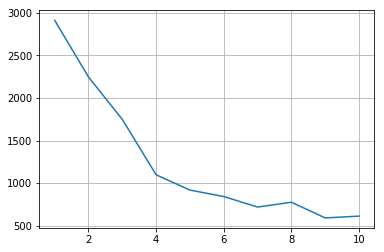

In [56]:

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 


plt.plot(ks,Errors )
plt.grid(True)

In [ ]:
sc.stop()